 This is called the wisdom of the crowd. Similarly, if you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of pre‐
dictors is called an ensemble; thus, this technique is called Ensemble Learning, and an
Ensemble Learning algorithm is called an Ensemble method

To make predictions, you just obtain the predictions of all individual trees, then predict the
class that gets the most votes. Such an ensemble of Decision Trees is called a Random Forest

**Voting Classifiers**

In [10]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [11]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


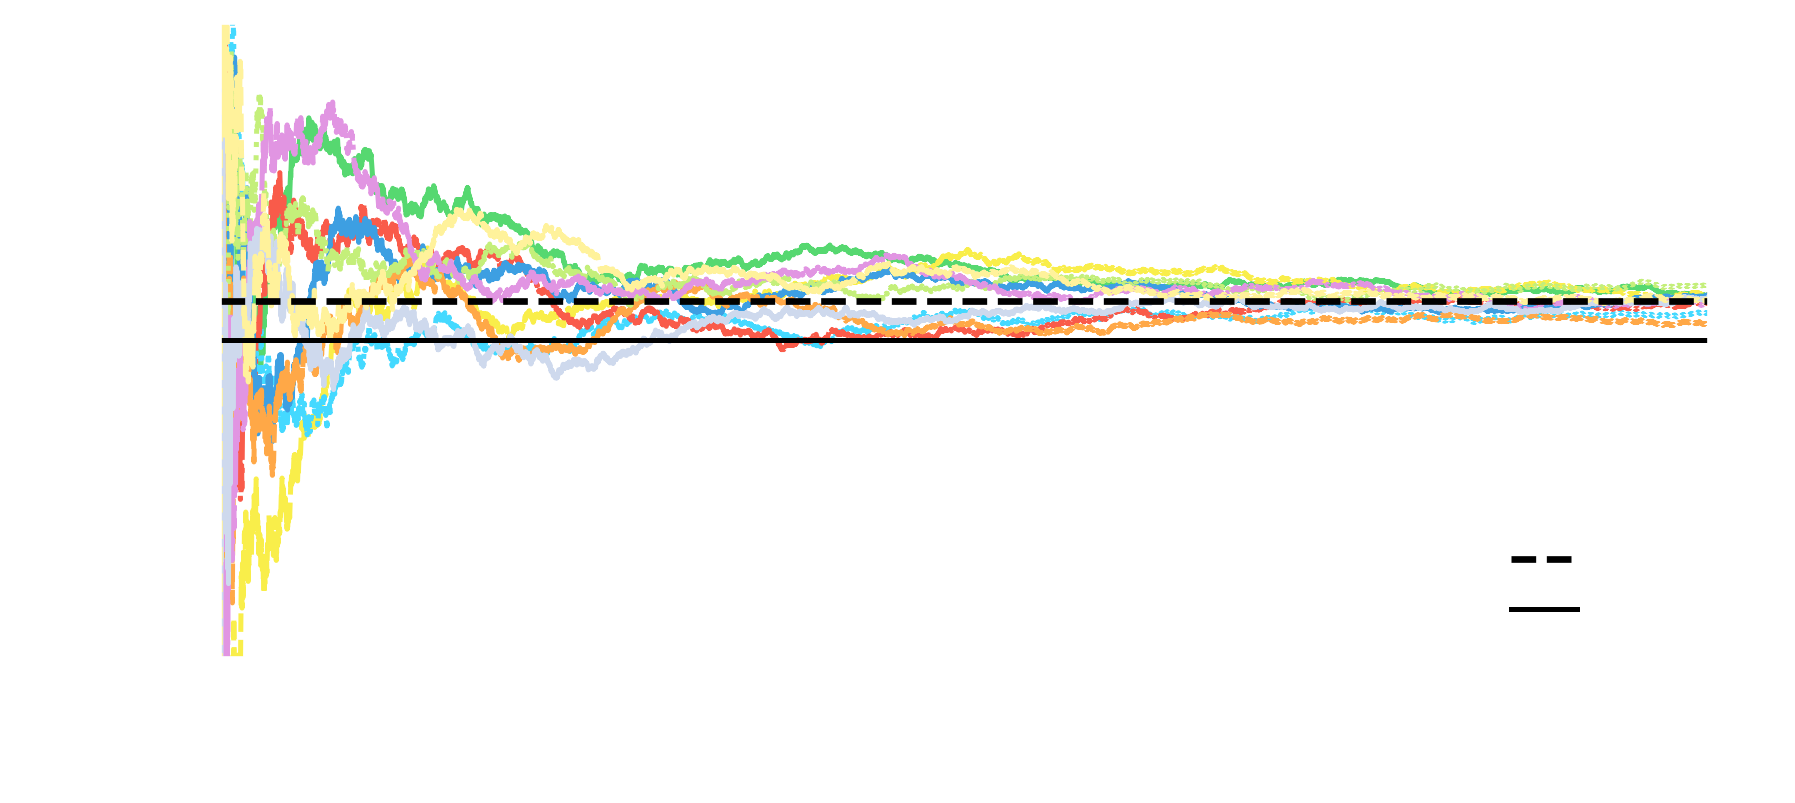

In [12]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show();

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [23]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.896
VotingClassifier 0.896


If all classifiers are able to estimate class probabilities (i.e., they have a pre
dict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called soft
voting It often achieves higher performance than hard voting because it gives more
weight to highly confident votes

**Voting="Soft"**

If all classifiers are able to estimate class probabilities (i.e., they have a pre
dict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called so
voting. It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities. This is
not the case of the SVC class by default, so you need to set its probability hyperpara‐
meter to True (this will make the SVC class use cross-validation to estimate class prob‐
abilities, slowing down training, and it will add a predict_proba() method). 

In [27]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [28]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


**Bagging and Pasting**

Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical mode (i.e., the most frequent prediction, just like a
hard voting classifier) for classification, or the average for regression. Each individual
predictor has a higher bias than if it were trained on the original training set, but
aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a
similar bias but a lower variance than a single predictor trained on the
original training set.


Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClas
sifier class (or BaggingRegressor for regression). The following code trains an
ensemble of 500 Decision Tree classifiers,5
each trained on 100 training instances ran‐
domly sampled from the training set with replacement (this is an example of bagging,
but if you want to use pasting instead, just set bootstrap=False). The n_jobs param‐
eter tells Scikit-Learn the number of CPU cores to use for training and predictions
(–1 tells Scikit-Learn to use all available cores)



In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both
trained on the moons dataset. As you can see, the ensemble’s predictions will likely
generalize much better than the single Decision Tree’s predictions: the ensemble has a
comparable bias but a smaller variance (it makes roughly the same number of errors
on the training set, but the decision boundary is less irregular)

In [31]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.928


In [32]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [33]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

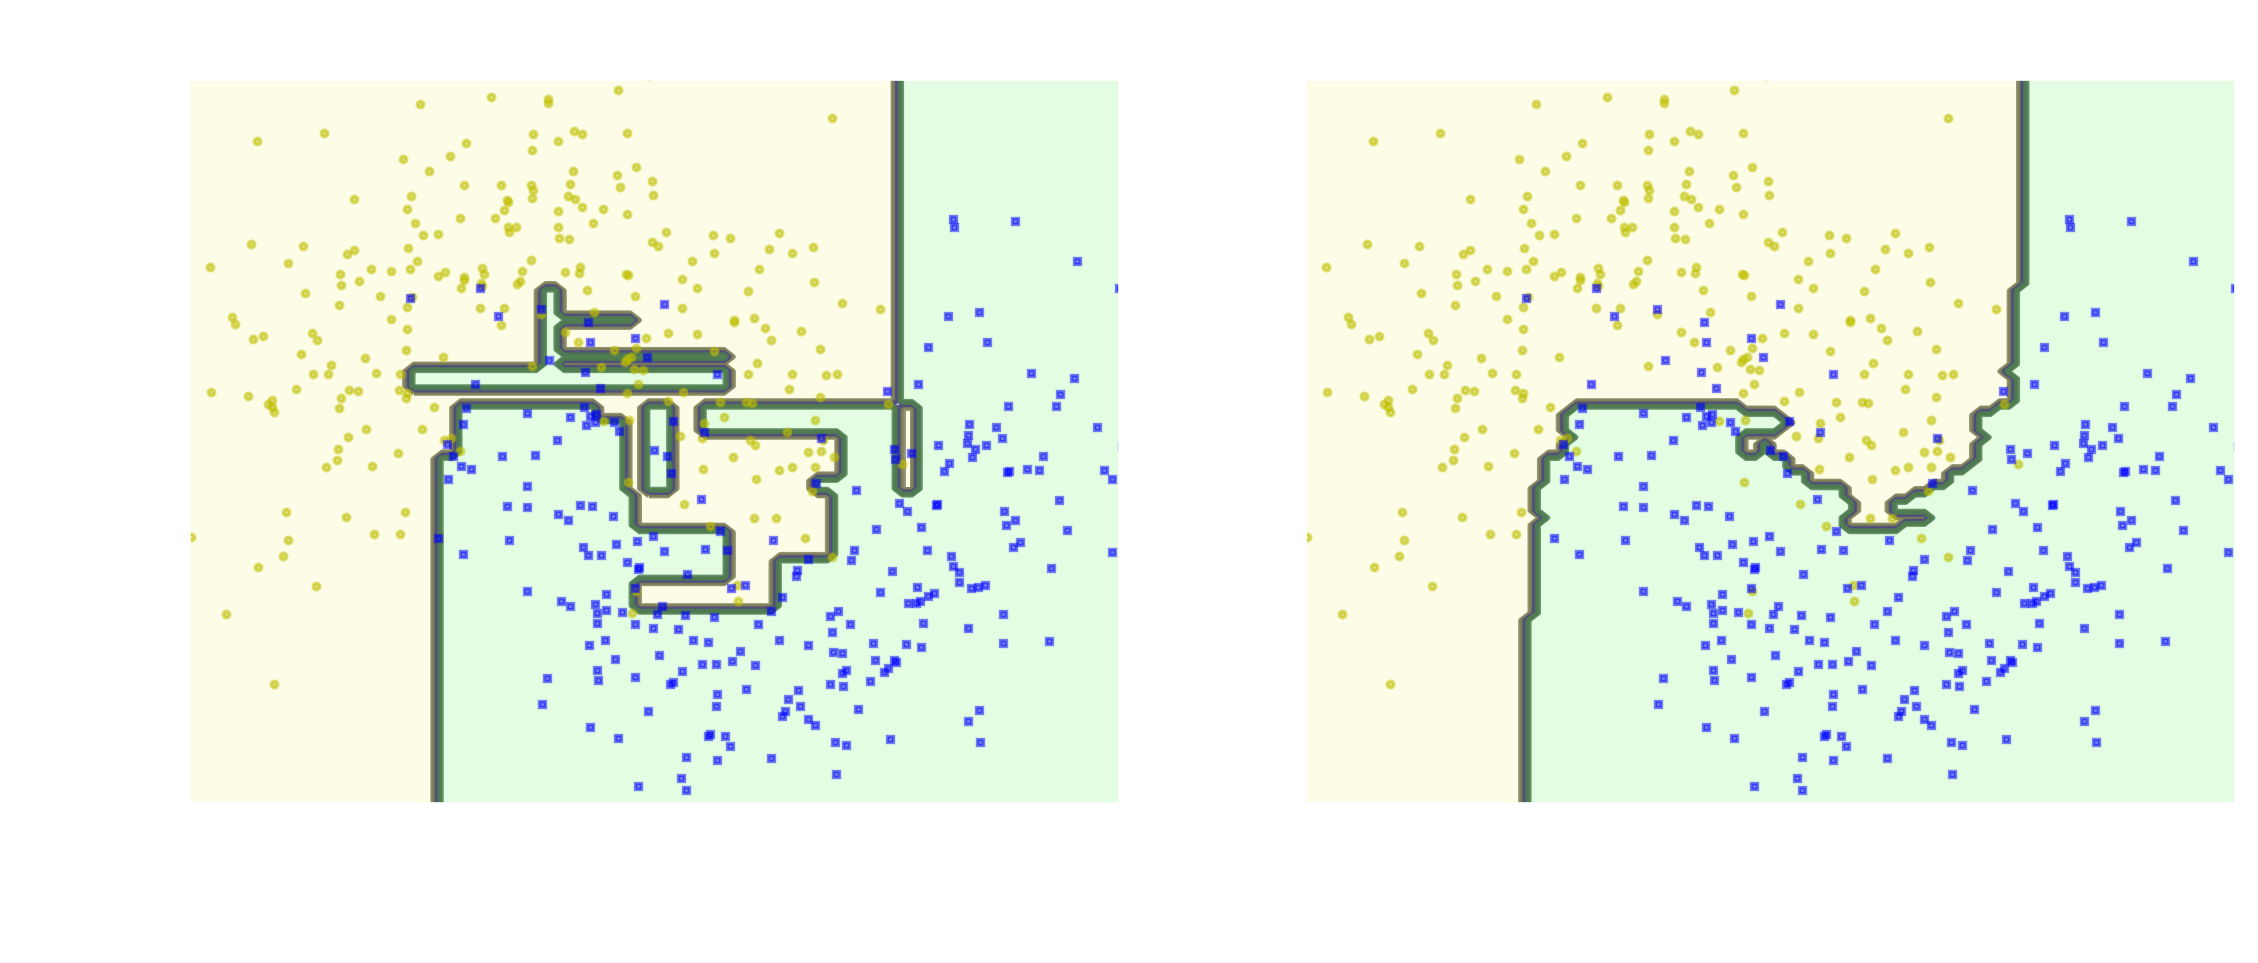

In [35]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show();

Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting, but this also
means that predictors end up being less correlated so the ensemble’s variance is
reduced. Overall, bagging often results in better models, which explains why it is gen‐
erally preferred. However, if you have spare time and CPU power you can use crossvalidation to evaluate both bagging and pasting and select the one that works best.

**Out-of-Bag Evaluation**

With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor.6
 The remaining 37% of the training instances that are not
sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
for all predictors.
Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set or cross-validation. You
can evaluate the ensemble itself by averaging out the oob evaluations of each predic‐
tor.


In [37]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [38]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [39]:
bag_clf.oob_decision_function_

array([[0.38918919, 0.61081081],
       [0.35632184, 0.64367816],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06989247, 0.93010753],
       [0.30857143, 0.69142857],
       [0.01162791, 0.98837209],
       [0.99438202, 0.00561798],
       [0.98275862, 0.01724138],
       [0.79234973, 0.20765027],
       [0.01204819, 0.98795181],
       [0.82716049, 0.17283951],
       [0.82417582, 0.17582418],
       [0.96373057, 0.03626943],
       [0.05555556, 0.94444444],
       [0.        , 1.        ],
       [0.98429319, 0.01570681],
       [0.92528736, 0.07471264],
       [0.98924731, 0.01075269],
       [0.03      , 0.97      ],
       [0.35326087, 0.64673913],
       [0.92090395, 0.07909605],
       [1.        , 0.        ],
       [0.94736842, 0.05263158],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.67368421, 0.32631579],
       [0.

**Random Forest**

In [40]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node (see Chapter 6), it
searches for the best feature among a random subset of features. This results in a
greater tree diversity, which (once again) trades a higher bias for a lower variance,
generally yielding an overall better model.

In [42]:
# Bagging Classifier similar to the RandomForestClassifier
# The BaggingClassifier class remains useful if you want a bag of something other than Decision Trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

**Feature Importance**

Lastly, if you look at a single Decision Tree, important features are likely to appear
closer to the root of the tree, while unimportant features will often appear closer to
the leaves (or not at all). It is therefore possible to get an estimate of a feature’s impor‐
tance by computing the average depth at which it appears across all trees in the forest.
Scikit-Learn computes this automatically for every feature after training. You can
access the result using the feature_importances_ variable.

In [45]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [46]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [50]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [51]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation='nearest')
    plt.axis('off');

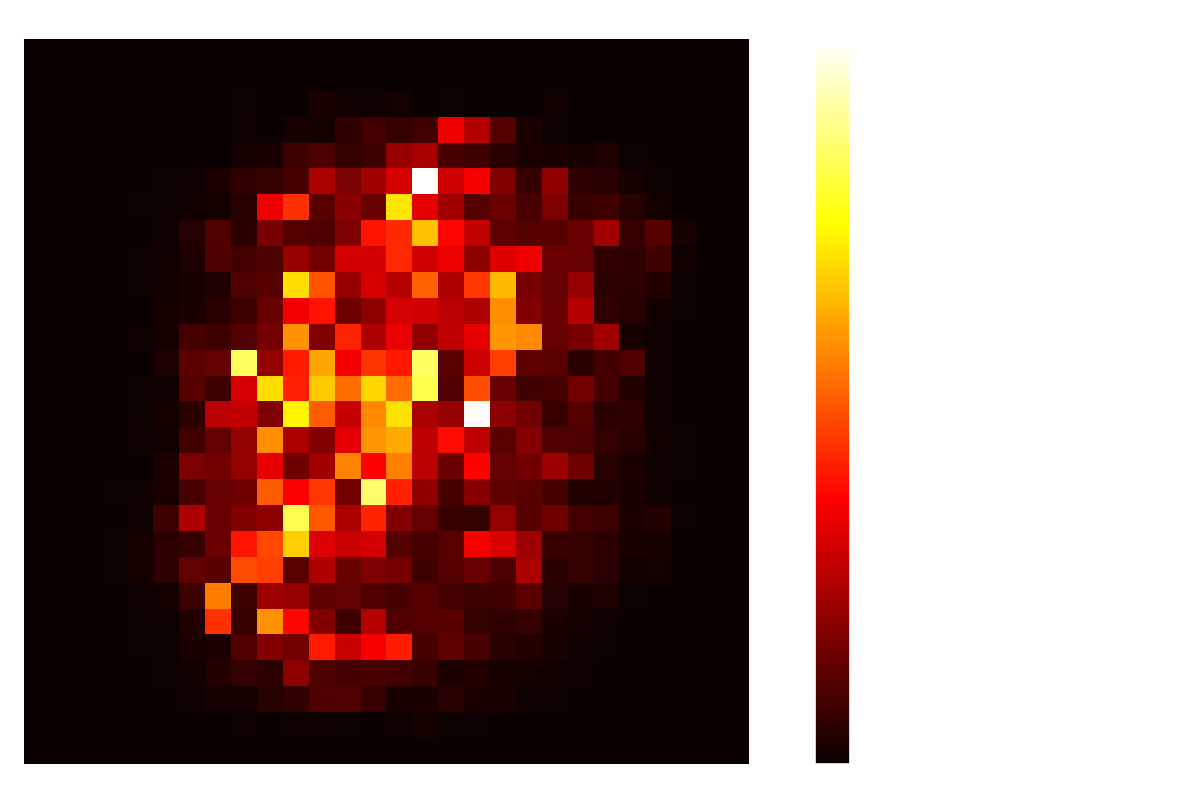

In [55]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

Random Forests are very handy to get a quick understanding of what features
actually matter, in particular if you need to perform feature selection.

**Boosting**

Boosting (originally called hypothesis boosting) refers to any Ensemble method that
can combine several weak learners into a strong learner. The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its prede‐
cessor. There are many boosting methods available, but by far the most popular are
AdaBoost13 (short for Adaptive Boosting) and Gradient Boosting.

**AdaBoost**

The first classifier gets many instances wrong, so their weights
get boosted. The second classifier therefore does a better job on these instances, and
so on. The plot on the right represents the same sequence of predictors except that
the learning rate is halved (i.e., the misclassified instance weights are boosted half as
much at every iteration). As you can see, this sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
gradually making it better.

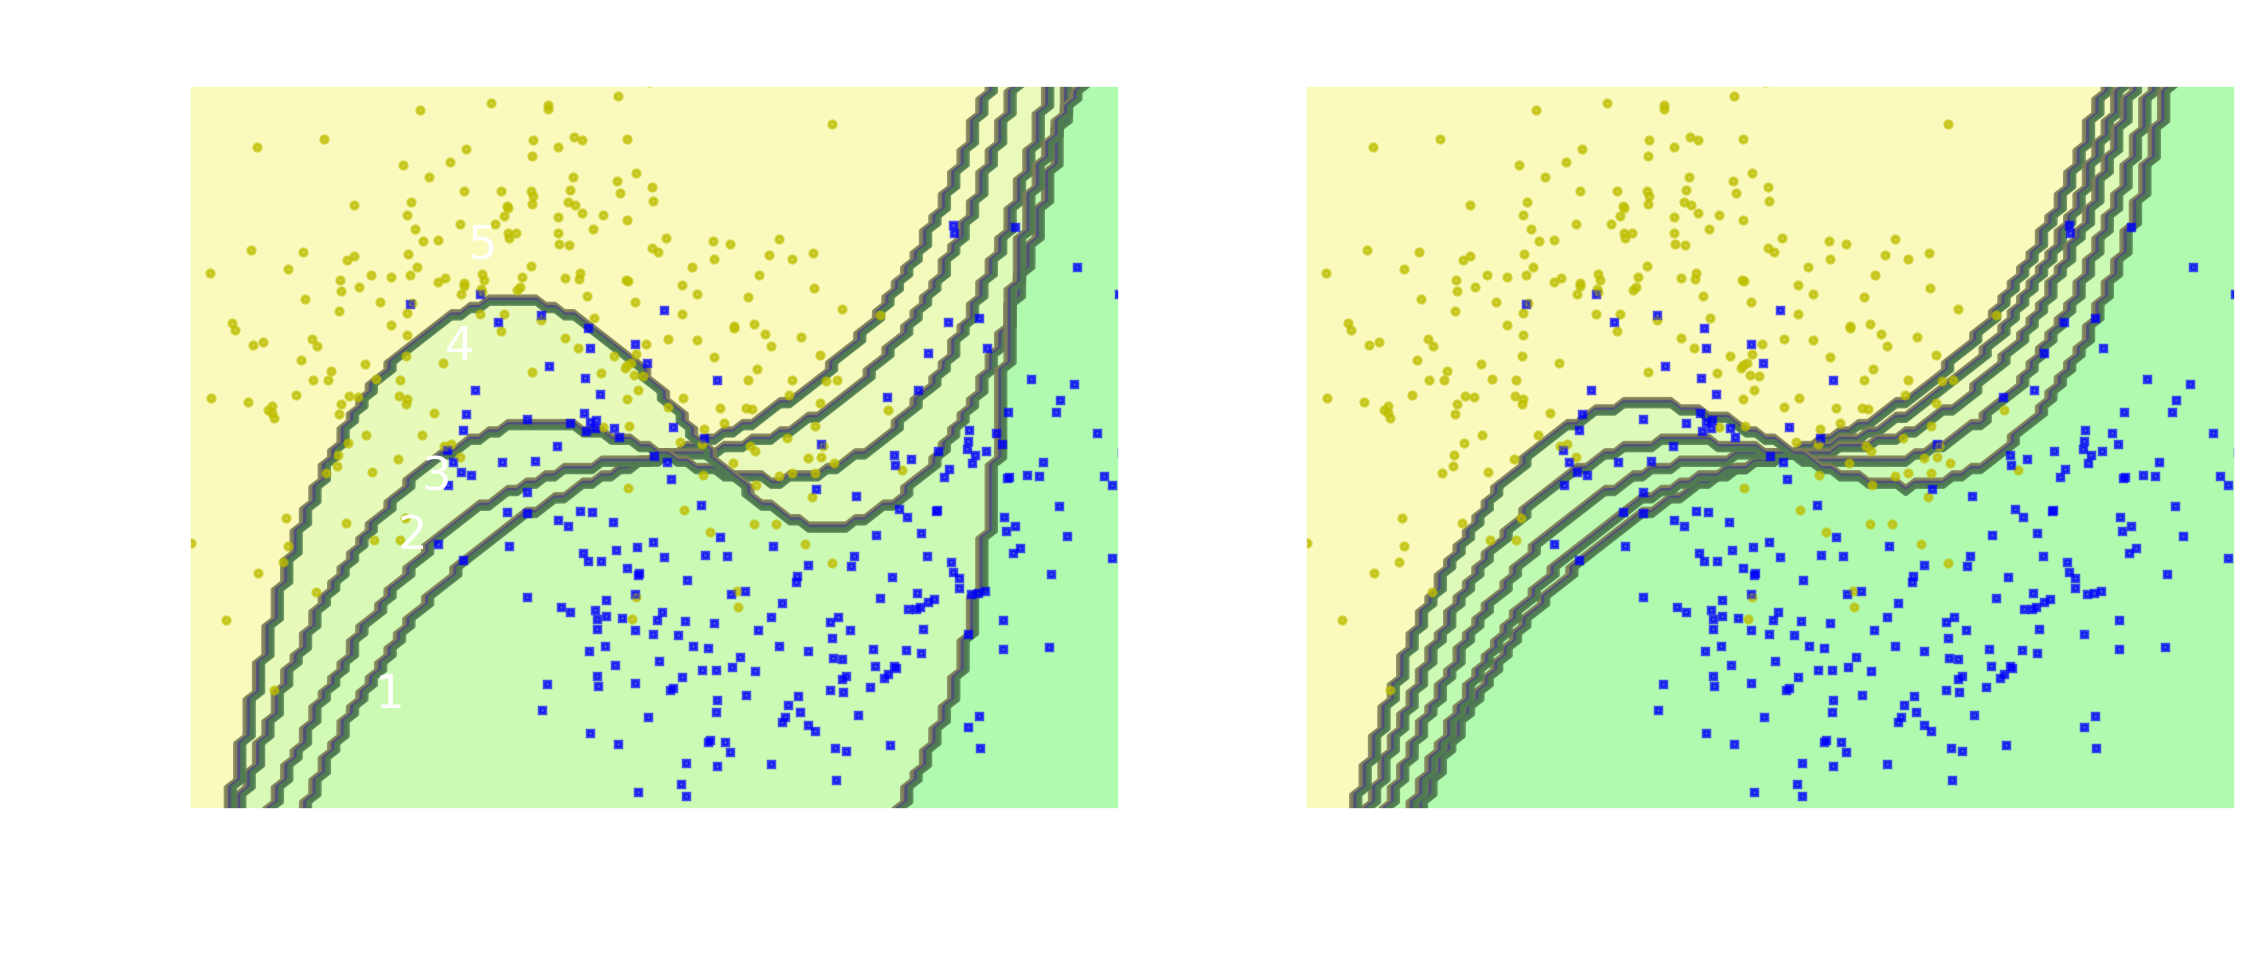

In [58]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show();

In [59]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

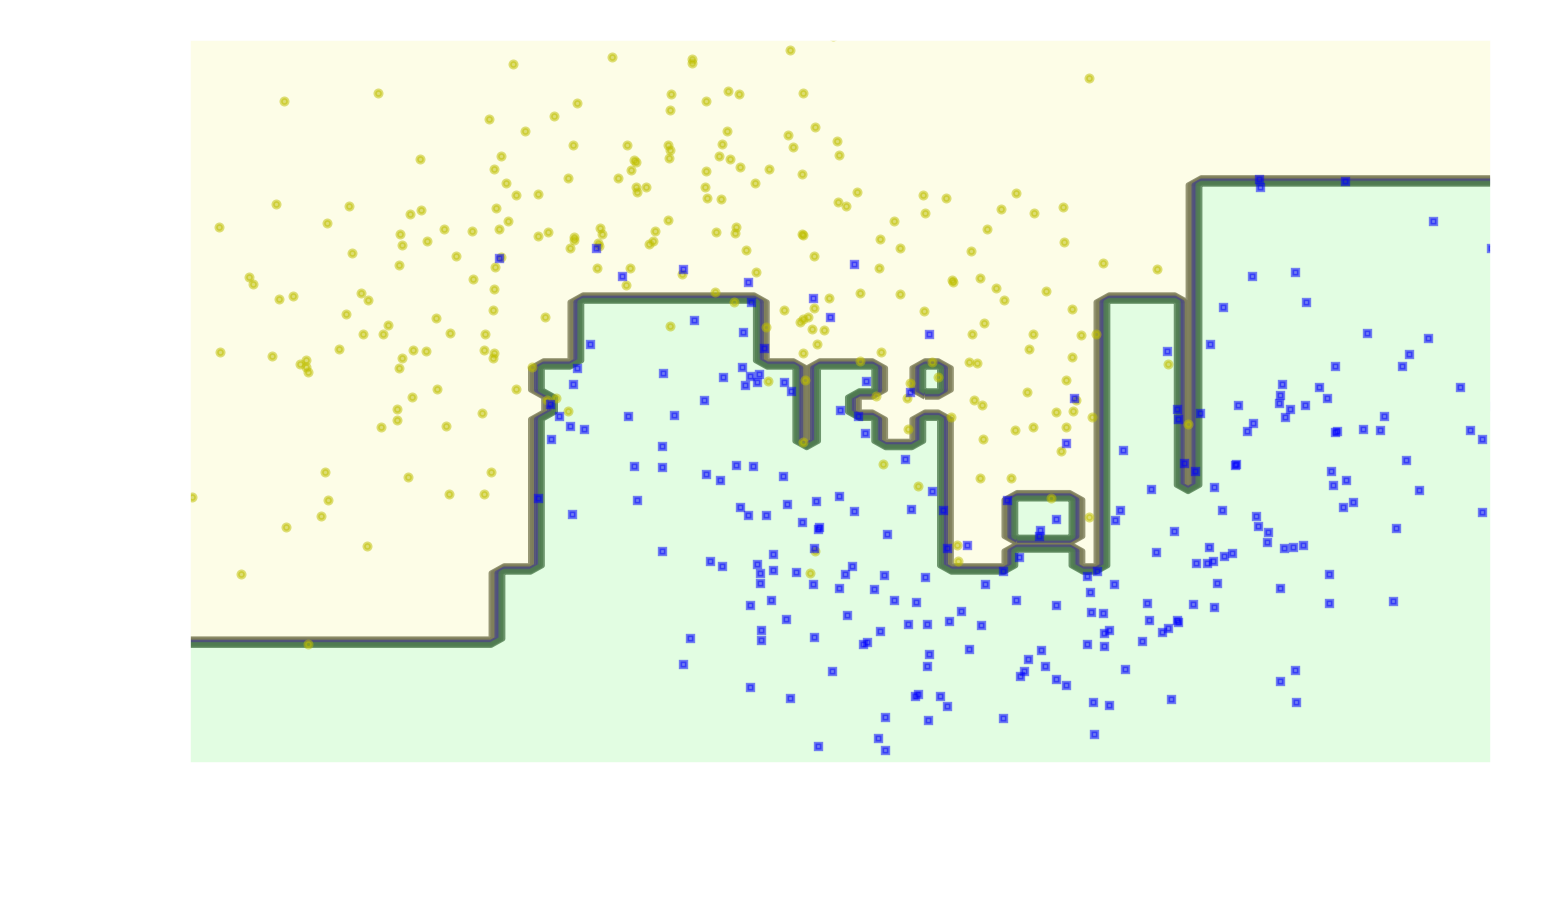

In [60]:
plot_decision_boundary(ada_clf, X, y)

The more accurate the predictor is, the
higher its weight will be. If it is just guessing randomly, then its weight will be close to
zero. However, if it is most often wrong (i.e., less accurate than random guessing),
then its weight will be negative.

Finally, a new predictor is trained using the updated weights, and the whole process is
repeated (the new predictor’s weight is computed, the instance weights are updated,
then another predictor is trained, and so on). The algorithm stops when the desired
number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors
and weighs them using the predictor weights αj. The predicted class is the one that receives the majority of weighted votes

Scikit-Learn actually uses a multiclass version of AdaBoost called SAMME16 (which
stands for Stagewise Additive Modeling using a Multiclass Exponential loss function).
When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the
predictors can estimate class probabilities (i.e., if they have a predict_proba()
method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands
for “Real”), which relies on class probabilities rather than predictions and generally
performs better

In [61]:
# The following code trains an AdaBoost classifier based on 200 Decision Stumps using
# Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an Ada
# BoostRegressor class). A Decision Stump is a Decision Tree with max_depth=1—in
# other words, a tree composed of a single decision node plus two leaf nodes. This is
# the default base estimator for the AdaBoostClassifier class:

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

**Gradient Boosting**

Another very popular Boosting algorithm is Gradient Boosting. Just like AdaBoost,
Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.

In [66]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [67]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [68]:
# Now train a second DecisionTreeRegressor on the residual errors made by the first predictor:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [69]:
# Then we train a third regressor on the residual errors made by the second predictor:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [71]:

X_new = np.array([[0.8]])

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:


In [72]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [73]:
y_pred

array([0.75026781])

the predictions of these three trees in the left column, and the
ensemble’s predictions in the right column. In the first row, the ensemble has just one
tree, so its predictions are exactly the same as the first tree’s predictions. In the second
row, a new tree is trained on the residual errors of the first tree. On the right you can
see that the ensemble’s predictions are equal to the sum of the predictions of the first
two trees. Similarly, in the third row another tree is trained on the residual errors of
the second tree. You can see that the ensemble’s predictions gradually get better as
trees are added to the ensemble.

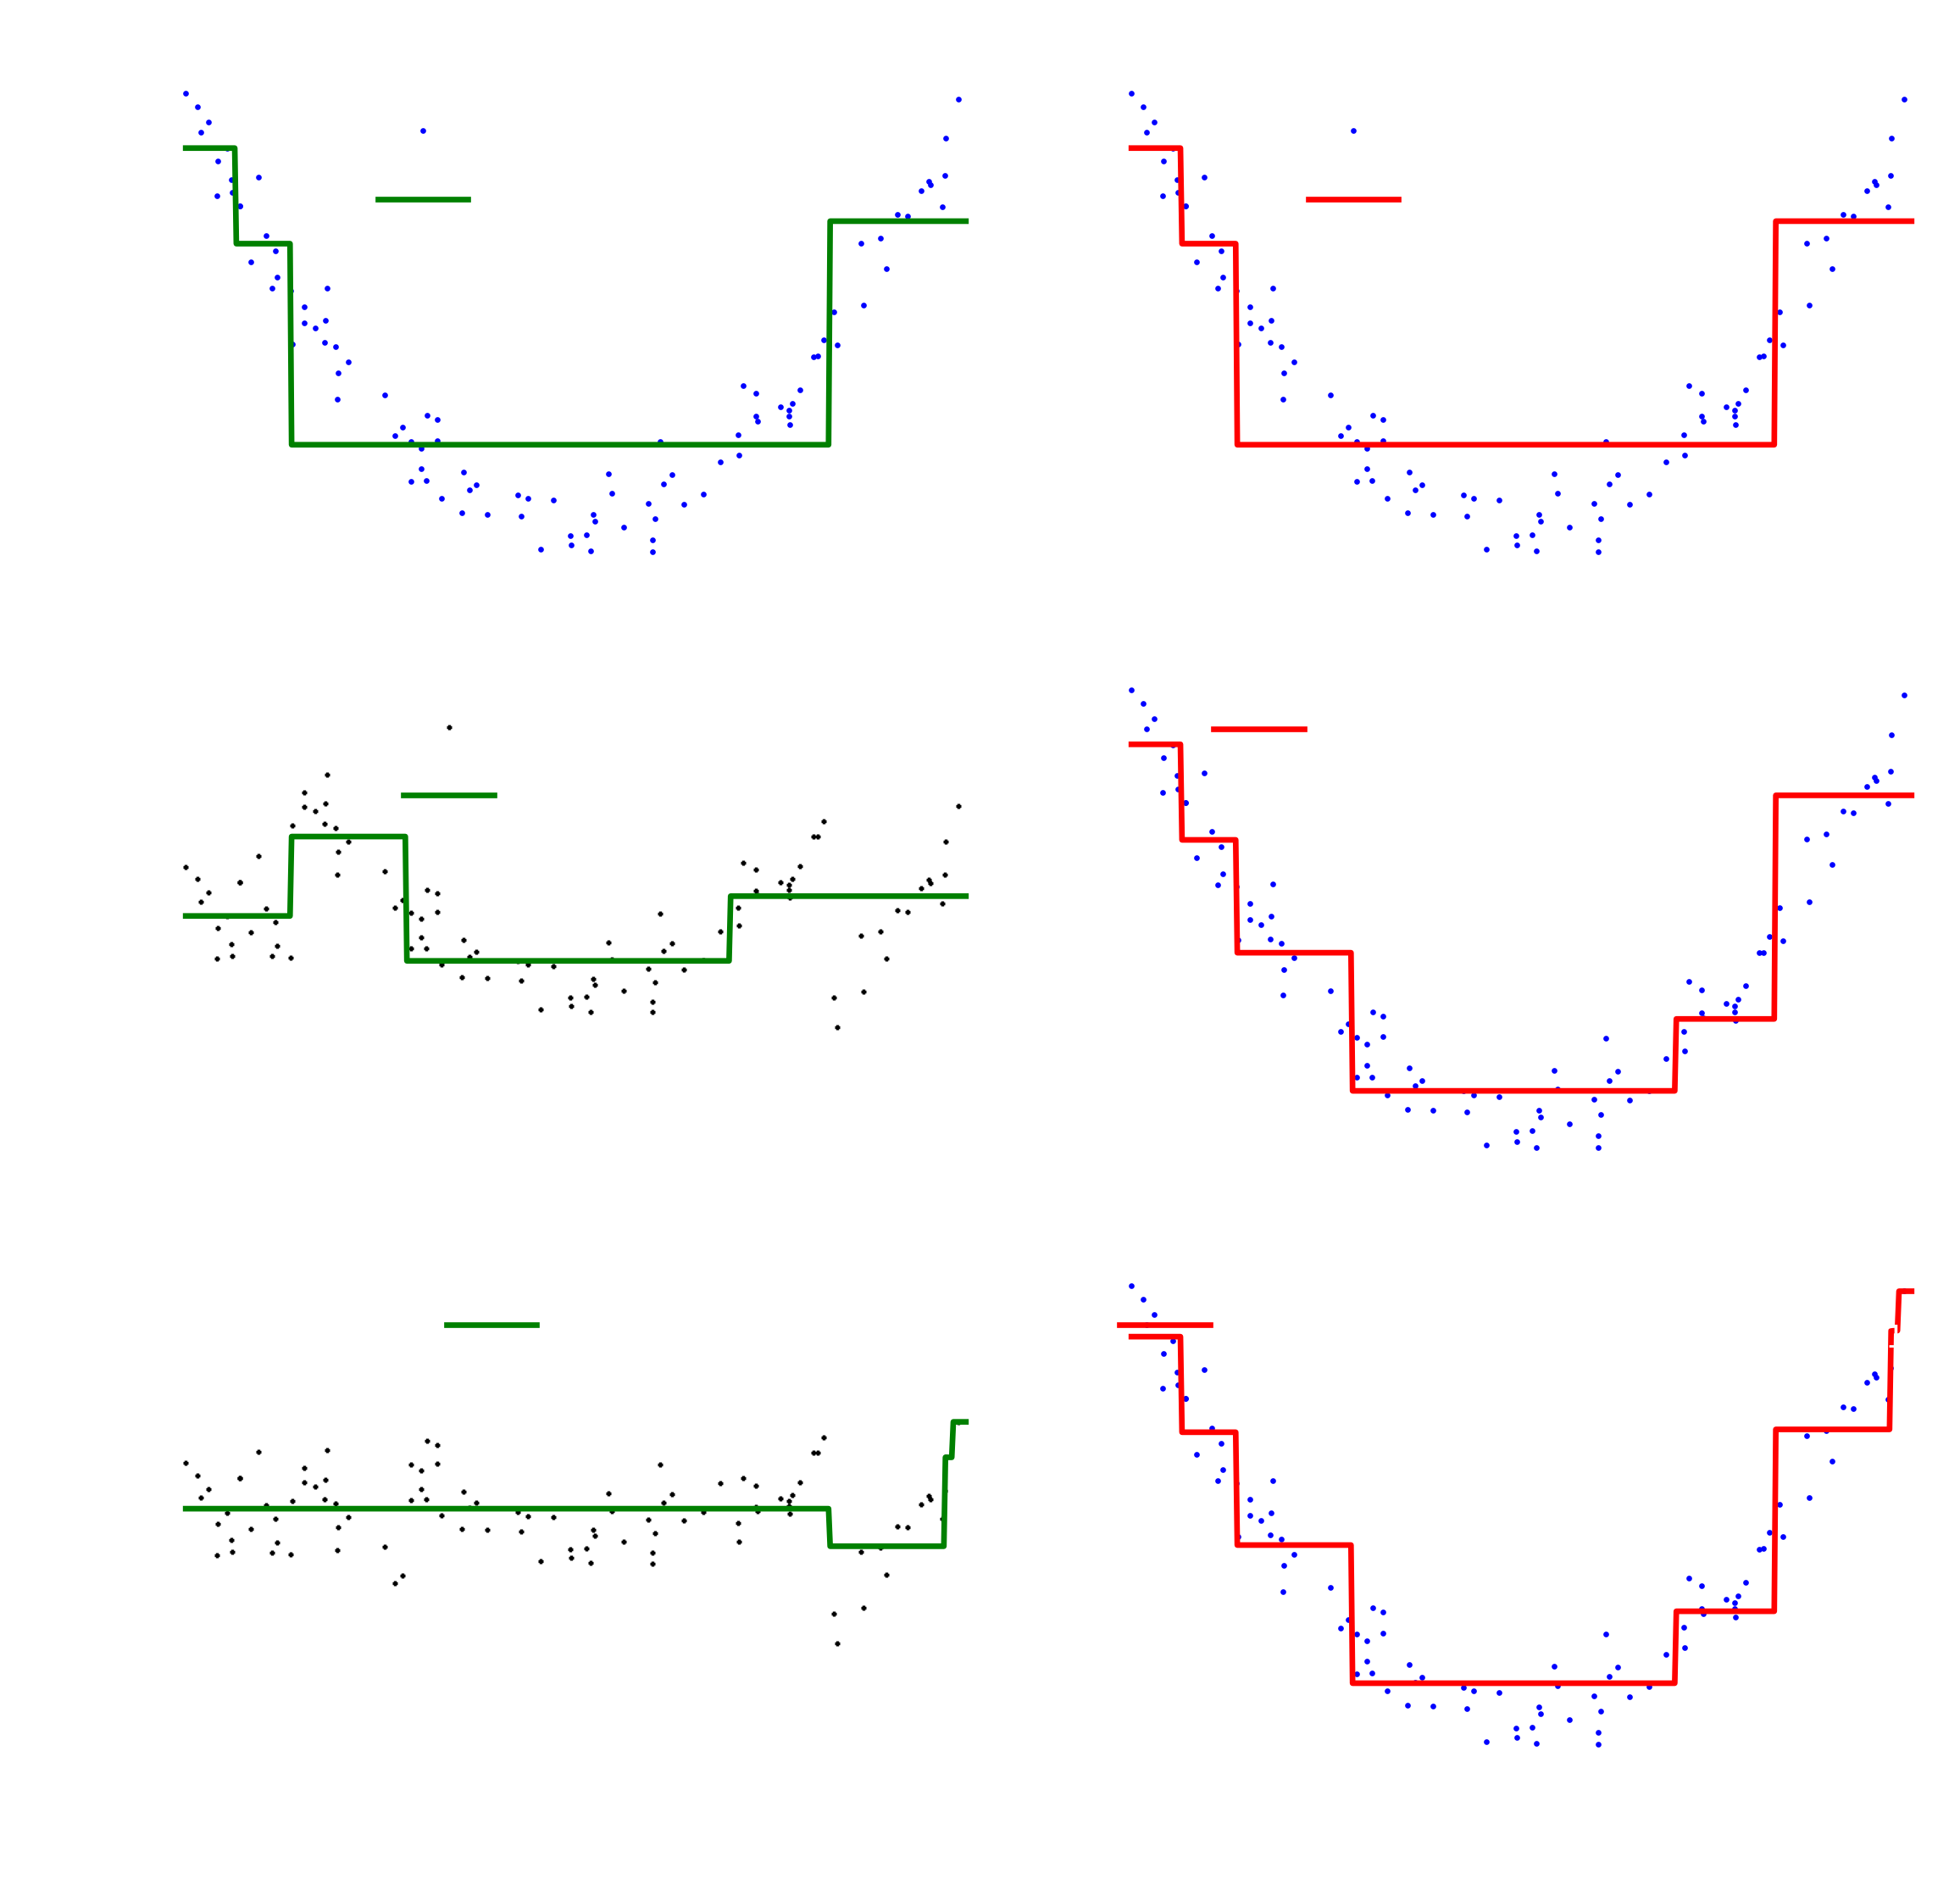

In [74]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

The learning_rate hyperparameter scales the contribution of each tree. If you set it
to a low value, such as 0.1, you will need more trees in the ensemble to fit the train‐
ing set, but the predictions will usually generalize better. This is a regularization tech‐
nique called shrinkage. Figure 7-10 shows two GBRT ensembles trained with a low
learning rate: the one on the left does not have enough trees to fit the training set,
while the one on the right has too many trees and overfits the training set.

In [77]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [78]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

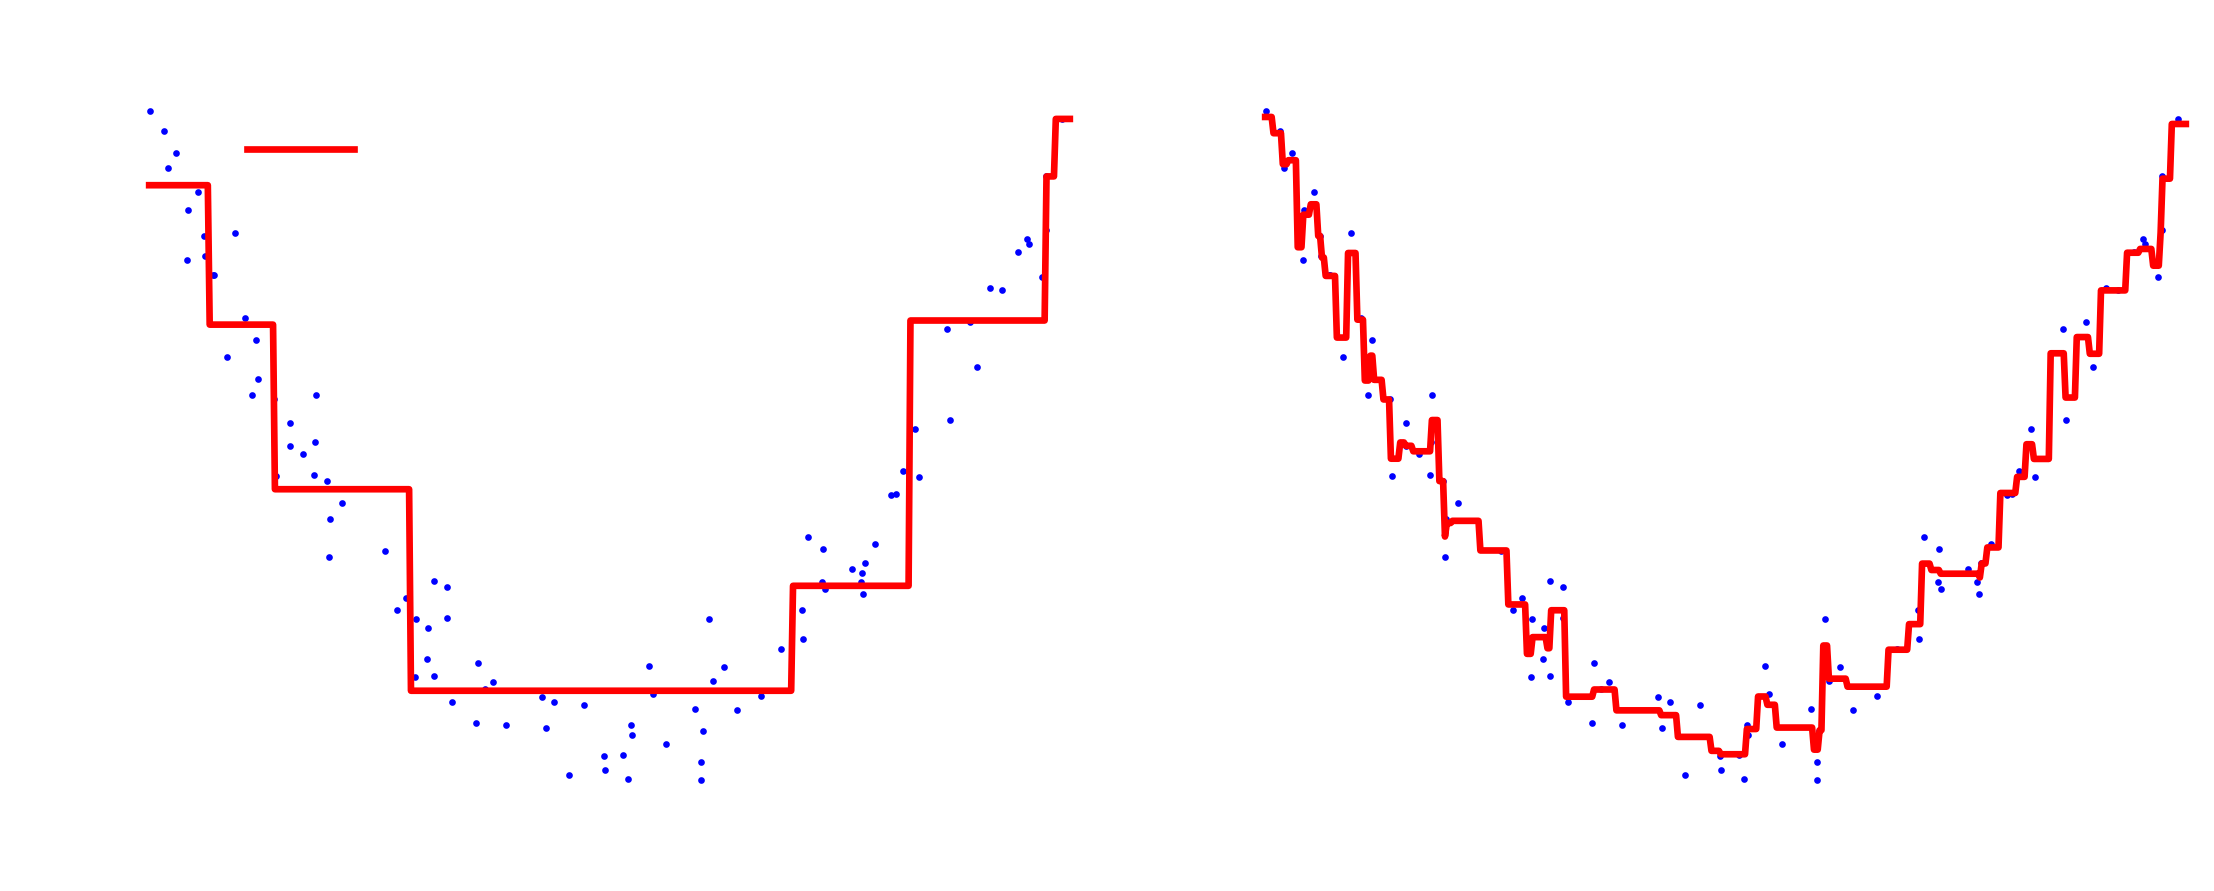

In [79]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.show()

A simple way to implement this is to use the staged_predict() method: it
returns an iterator over the predictions made by the ensemble at each stage of train‐
ing (with one tree, two trees, etc.). The following code trains a GBRT ensemble with
120 trees, then measures the validation error at each stage of training to find the opti‐
mal number of trees, and finally trains another GBRT ensemble using the optimal
number of trees:

In [89]:
# Tuning the number of trees using early stopping
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=55,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [90]:
min_error = np.min(errors)

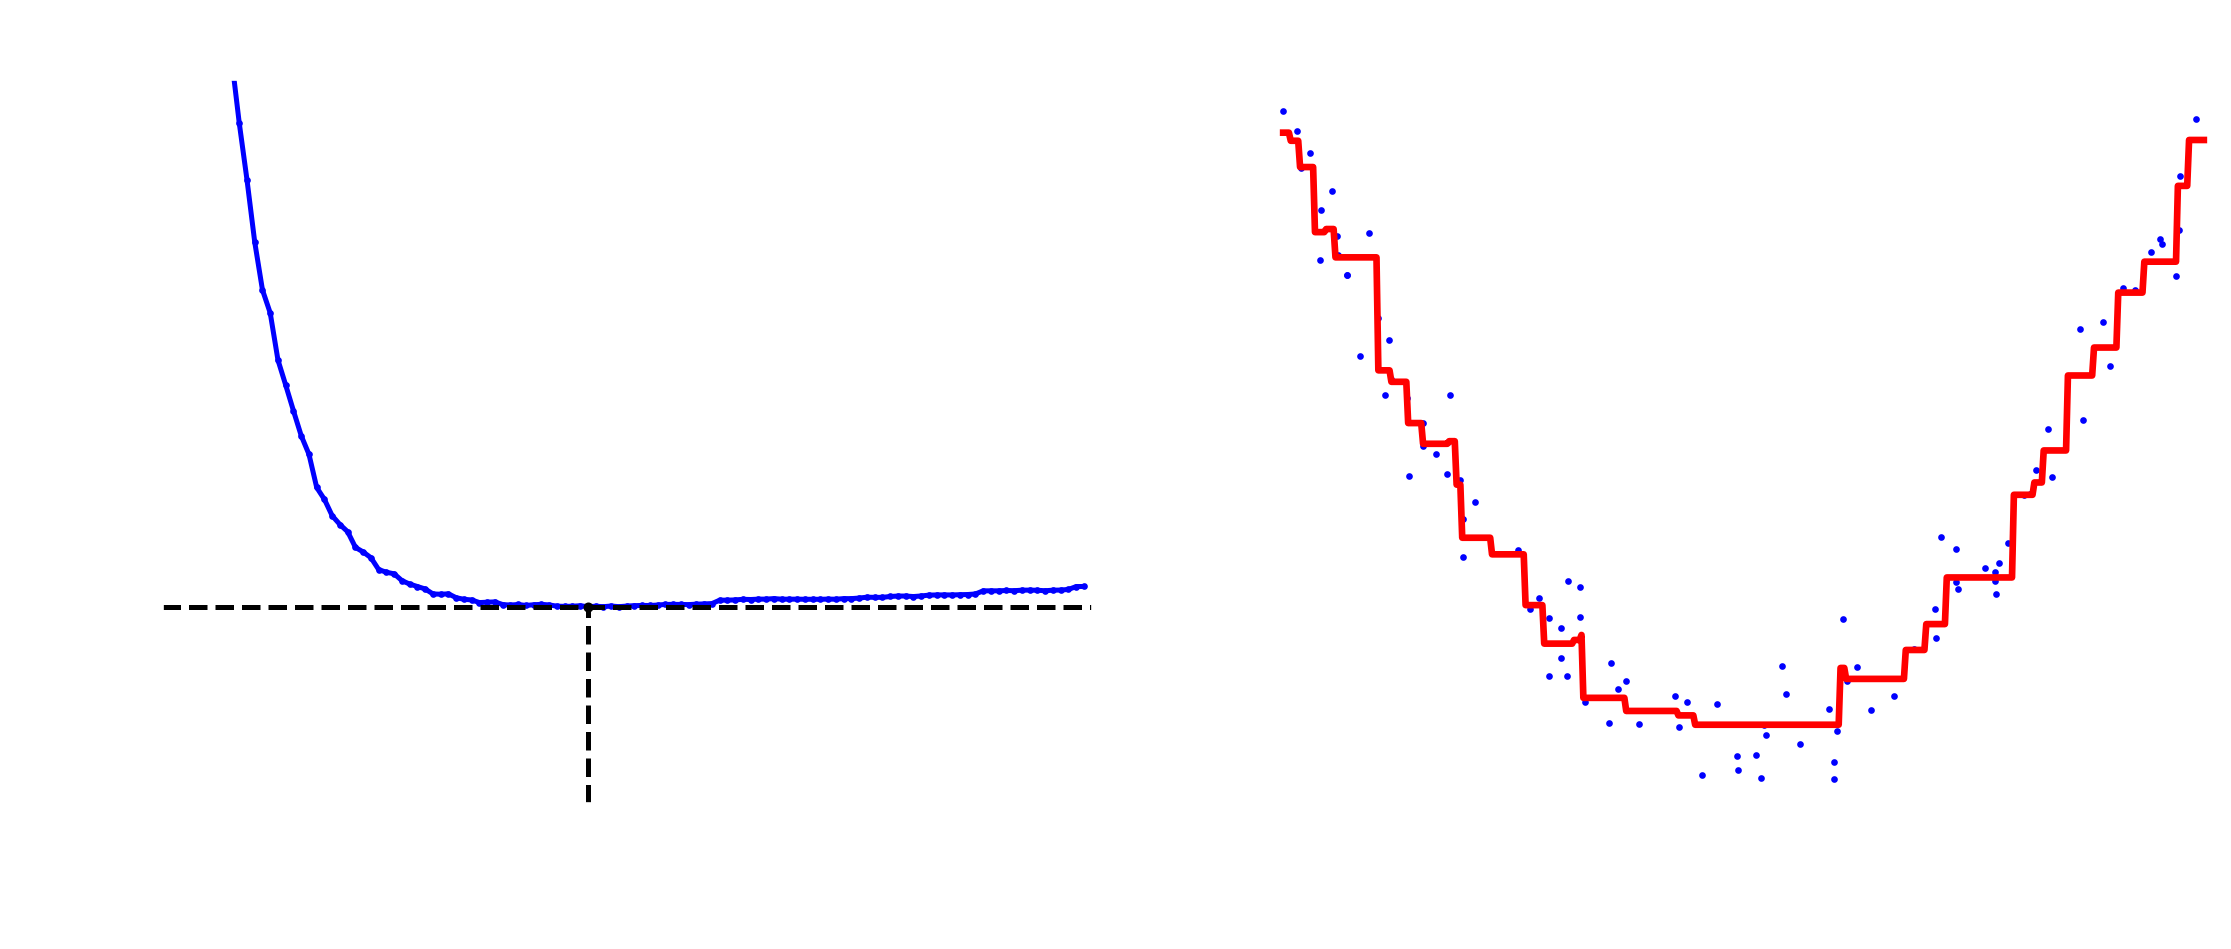

In [91]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.show()

The following code stops training when the validation error does not
improve for five iterations in a row (warm_start=True):

In [95]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [96]:
print(gbrt.n_estimators)

61


In [97]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


In [ ]:
It is actually possible to train several different blenders this way (e.g., one using Lin‐
ear Regression, another using Random Forest Regression, and so on): we get a whole
layer of blenders. The trick is to split the training set into three subsets: the first one is
used to train the first layer, the second one is used to create the training set used to
train the second layer (using predictions made by the predictors of the first layer),
and the third one is used to create the training set to train the third layer (using pre‐
dictions made by the predictors of the second layer). Once this is done, we can make
a prediction for a new instance by going through each layer sequentially

Exercises
1. If you have trained five different models on the exact same training data, and
they all achieve 95% precision, is there any chance that you can combine these
models to get better results? If so, how? If not, why?
If you have trained five different models and they all achieve 95% precision, you
can try combining them into a voting ensemble, which will often give you even
better results. It works better if the models are very different (e.g., an SVM classi‐
fier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is
even better if they are trained on different training instances (that’s the whole
point of bagging and pasting ensembles), but if not it will still work as long as the
models are very different.

2. What is the difference between hard and soft voting classifiers?
A hard voting classifier just counts the votes of each classifier in the ensemble
and picks the class that gets the most votes. A soft voting classifier computes the
average estimated class probability for each class and picks the class with the
highest probability. This gives high-confidence votes more weight and often per‐
forms better, but it works only if every classifier is able to estimate class probabil‐
ities (e.g., for the SVM classifiers in Scikit-Learn you must set
probability=True).

3. Is it possible to speed up training of a bagging ensemble by distributing it across
multiple servers? What about pasting ensembles, boosting ensembles, random
forests, or stacking ensembles?
It is quite possible to speed up training of a bagging ensemble by distributing it
across multiple servers, since each predictor in the ensemble is independent of
the others. The same goes for pasting ensembles and Random Forests, for the
same reason. However, each predictor in a boosting ensemble is built based on
the previous predictor, so training is necessarily sequential, and you will not gain
anything by distributing training across multiple servers. Regarding stacking
ensembles, all the predictors in a given layer are independent of each other, so
they can be trained in parallel on multiple servers. However, the predictors in one
layer can only be trained after the predictors in the previous layer have all been
trained.

4. What is the benefit of out-of-bag evaluation?
With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated
using instances that it was not trained on (they were held out). This makes it pos‐
sible to have a fairly unbiased evaluation of the ensemble without the need for an
additional validation set. Thus, you have more instances available for training,
and your ensemble can perform slightly better.

5. What makes Extra-Trees more random than regular Random Forests? How can
this extra randomness help? Are ExtraTrees slower or faster than regular Random Forests?
When you are growing a tree in a Random Forest, only a random subset of the
features is considered for splitting at each node. This is true as well for ExtraTrees, but they go one step further: rather than searching for the best possible
thresholds, like regular Decision Trees do, they use random thresholds for each
feature. This extra randomness acts like a form of regularization: if a Random
Forest overfits the training data, Extra-Trees might perform better. Moreover,
since Extra-Trees don’t search for the best possible thresholds, they are much
faster to train than Random Forests. However, they are neither faster nor slower
than Random Forests when making predictions.


6. If your AdaBoost ensemble underfits the training data, what hyperparameters
should you tweak and how?
If your AdaBoost ensemble underfits the training data, you can try increasing the
number of estimators or reducing the regularization hyperparameters of the base
estimator. You may also try slightly increasing the learning rate.

7. If your Gradient Boosting ensemble overfits the training set, should you increase
or decrease the learning rate?
If your Gradient Boosting ensemble overfits the training set, you should try
decreasing the learning rate. You could also use early stopping to find the right
number of predictors (you probably have too many).
